# Exploring Models

This notebook aims to discover how different models perform and what features they perform well on. 

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from model_super import *
from models import *
from ensembler import *

Processing all the data. This potentially can change as well, but for now it is fine.

In [2]:
################################################ Load Data #############################################################

print('Loading data ...')

train = pd.read_csv('~/Desktop/zillow_data/train_2016.csv')
prop = pd.read_csv('~/Desktop/zillow_data/properties_2016.csv')
sample = pd.read_csv('~/Desktop/zillow_data/submission.csv')

############################################### Process Data ###########################################################

#Deal with NA Values
for c in prop.columns:
    prop[c]=prop[c].fillna(-1)

print('Binding to float32')

#Simplify Data Types
for c, dtype in zip(prop.columns, prop.dtypes):
	if dtype == np.float64:
		prop[c] = prop[c].astype(np.float32)

print('Creating training set ...')

df_train = train.merge(prop, how='left', on='parcelid')

#Remove outliers
df_train = df_train[df_train.logerror > -0.4]
df_train = df_train[df_train.logerror < 0.4]

#Drop bad columns
x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc',
                         'propertycountylandusecode', 'buildingclasstypeid', 'decktypeid',
                         'hashottuborspa', 'poolcnt', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'storytypeid',
                         'fireplaceflag', 'assessmentyear', 'taxdelinquencyflag'], axis=1)
y_train = df_train['logerror'].values
print(x_train.shape, y_train.shape)

categorical_cols = ['transaction_month', 'transaction_day', 'transaction_quarter', 'airconditioningtypeid',
                    'buildingqualitytypeid', 'fips', 'heatingorsystemtypeid', 'propertylandusetypeid', 'regionidcity',
                    'regionidcounty', 'regionidneighborhood','regionidzip', 'yearbuilt']

print("data types: ")
print(x_train.dtypes)

#perform mean normalization
num_changed = 0
for column in x_train:
    if column not in categorical_cols:
        mean = x_train[column].mean()
        stdev = x_train[column].std()
        if stdev != 0:
            x_train[column] = (x_train[column] - mean) / stdev
            num_changed += 1
print("number changed: ")
print(num_changed)

train_columns = x_train.columns

for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=27000)

Loading data ...


/Users/talhabaig/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning:

Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.



Binding to float32
Creating training set ...
((88431, 44), (88431,))
data types: 
airconditioningtypeid           float32
architecturalstyletypeid        float32
basementsqft                    float32
bathroomcnt                     float32
bedroomcnt                      float32
buildingqualitytypeid           float32
calculatedbathnbr               float32
finishedfloor1squarefeet        float32
calculatedfinishedsquarefeet    float32
finishedsquarefeet12            float32
finishedsquarefeet13            float32
finishedsquarefeet15            float32
finishedsquarefeet50            float32
finishedsquarefeet6             float32
fips                            float32
fireplacecnt                    float32
fullbathcnt                     float32
garagecarcnt                    float32
garagetotalsqft                 float32
heatingorsystemtypeid           float32
latitude                        float32
longitude                       float32
lotsizesquarefeet               float3

Training the models, so we can see what features they like the most.

In [3]:
######################################################## Training ######################################################

print('Training ...')

y_mean = y_train.mean()
#XGBoost params
xgb_params = {
    'eta': 0.035,
    'max_depth': 6,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'colsample_bytree': 0.9,
    'eval_metric': 'mae',
    'lambda': 0.8,
    'alpha': 0.4,
    'base_score': y_mean,
    'seed': 143,
    'silent': 1
}

# rf params
rf_params = {
    'n_estimators': 50,
    'max_depth': 8,
    'min_samples_split': 100,
    'min_samples_leaf': 30
}

#Extra Trees params
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 400,
    'learning_rate' : 0.75
}

#Second Layer XGBoost parameters
xgb_params_2 = {
            'eta': 0.037,
            'max_depth': 5,
            'subsample': 0.80,
            'objective': 'reg:linear',
            'eval_metric': 'mae',
            'lambda': 0.8,
            'alpha': 0.4,
            'silent': 1
        }

#Initialize all of the baseline models
random_forest = RandomForest(rf_params)
extra_trees = ExtraTrees(et_params)
ada_boost = AdaBoost(ada_params)
decision_tree = DecisionTree({})
xgboost = XGBoost(xgb_params)

Training ...


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

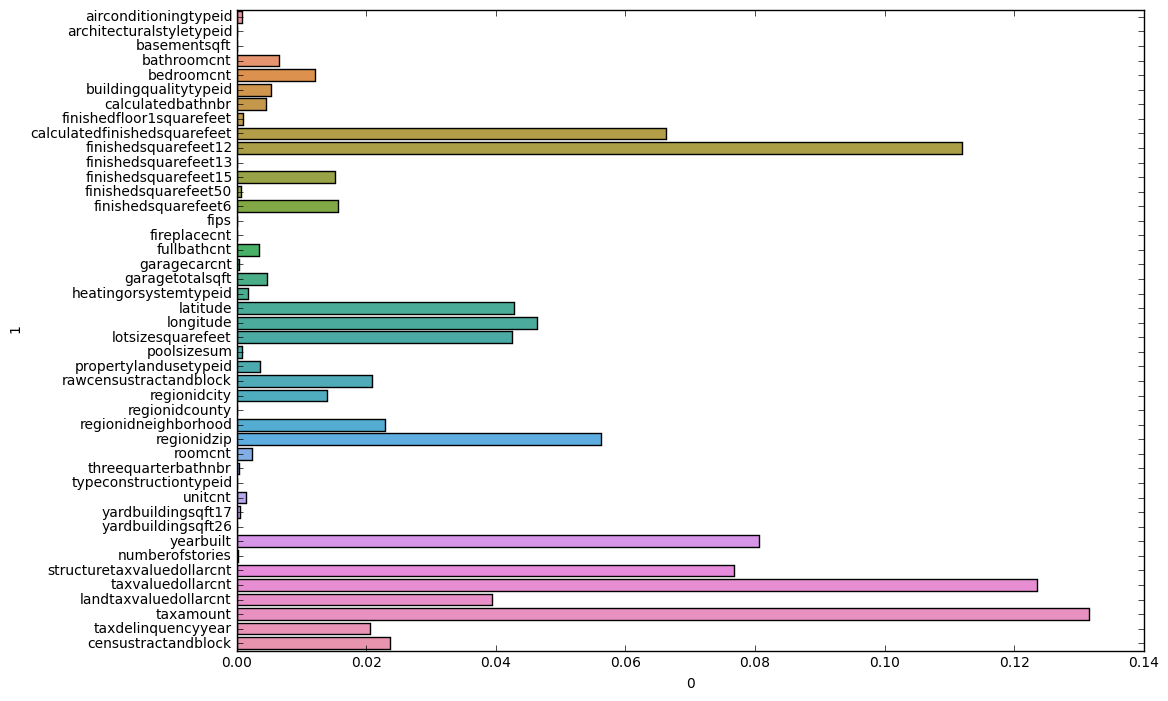

In [5]:
random_forest = RandomForestRegressor(**rf_params)
random_forest.fit(x_train, y_train)
random_forest.feature_importances_
x_train.columns
df = pd.DataFrame(zip(random_forest.feature_importances_, x_train.columns))
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax=ax, data=df, x=0, y=1)

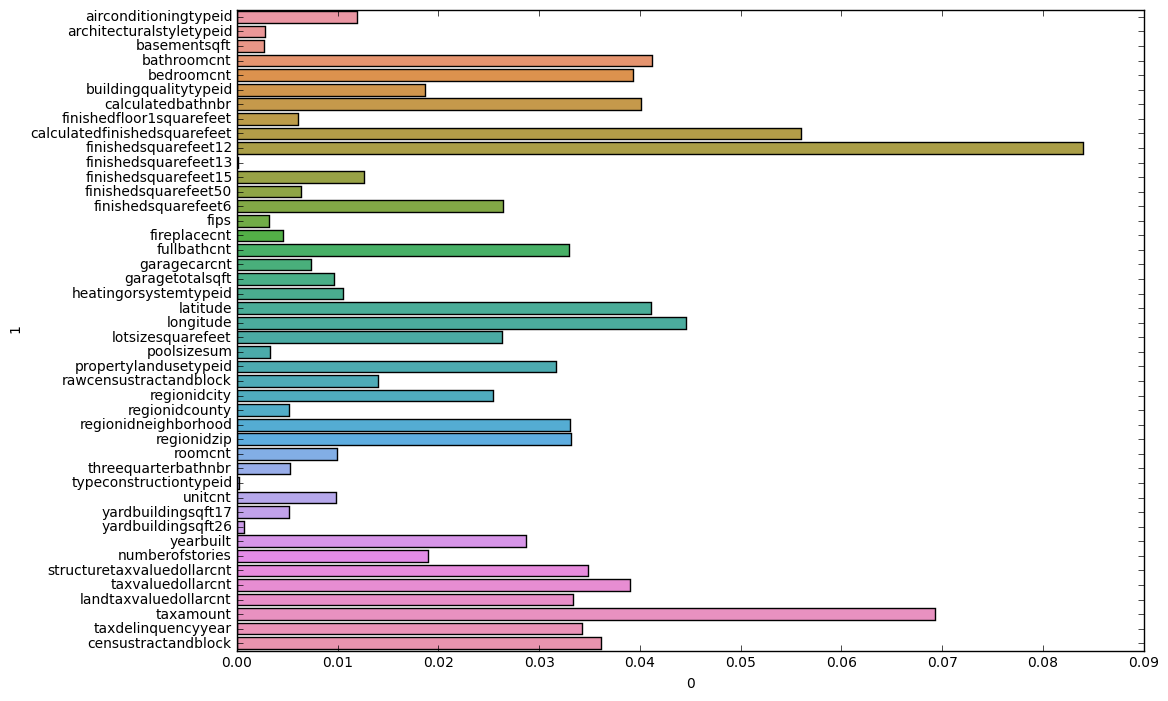

In [6]:
extra_trees = ExtraTreesRegressor(**et_params)
extra_trees.fit(x_train, y_train)
df = pd.DataFrame(zip(extra_trees.feature_importances_, x_train.columns))
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax=ax, data=df, x=0, y=1)

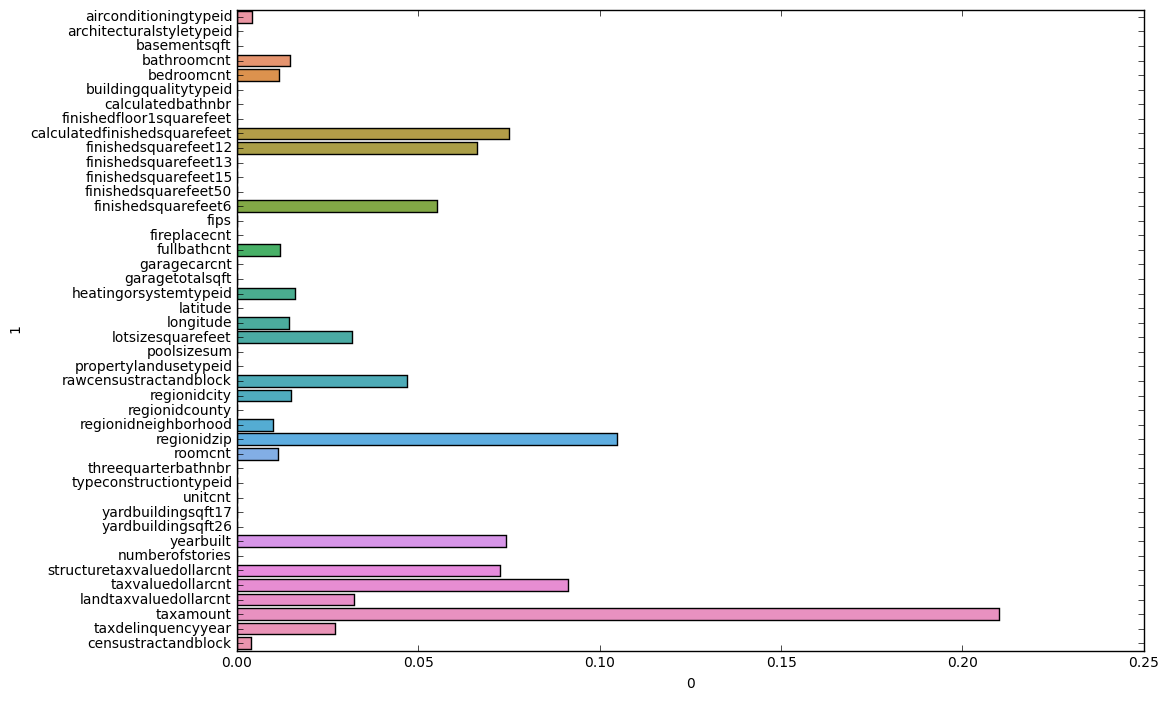

In [7]:
ada_boost = AdaBoostRegressor(**ada_params)
ada_boost.fit(x_train, y_train)
df = pd.DataFrame(zip(ada_boost.feature_importances_, x_train.columns))
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax=ax, data=df, x=0, y=1)

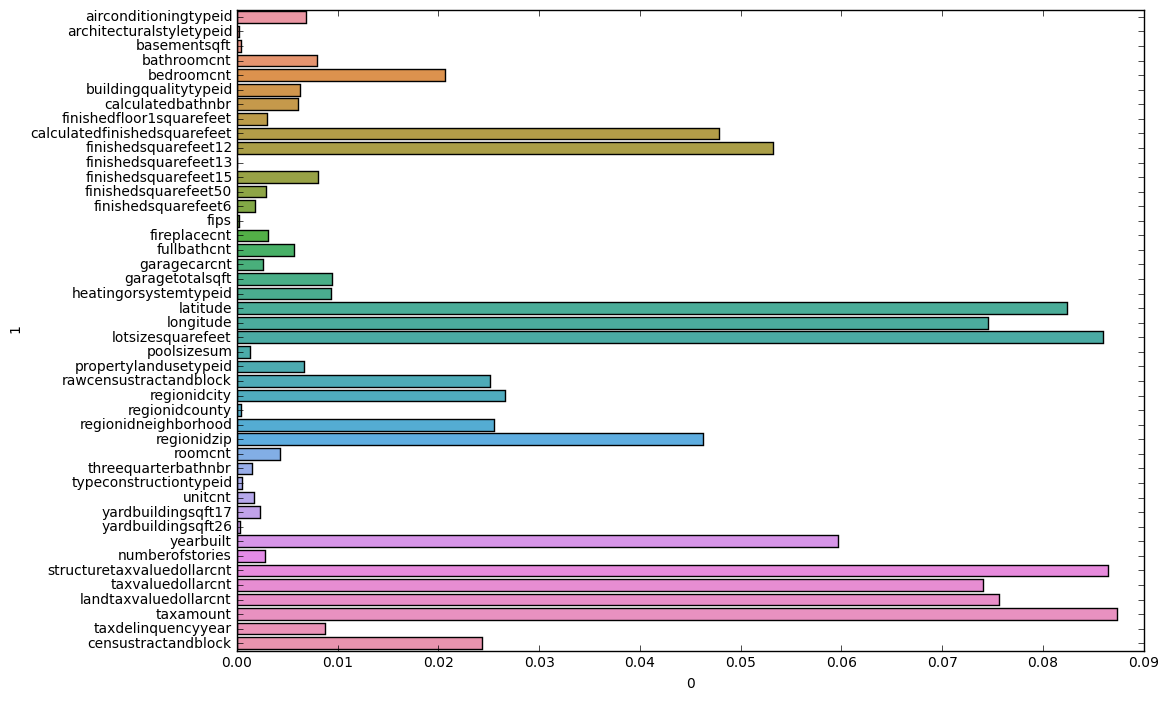

In [8]:
descision_tree = DecisionTreeRegressor(**{})
descision_tree.fit(x_train, y_train)
df = pd.DataFrame(zip(descision_tree.feature_importances_, x_train.columns))
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax=ax, data=df, x=0, y=1)

[0]	train-mae:0.052958
Will train until train-mae hasn't improved in 50 rounds.
[10]	train-mae:0.052607
[20]	train-mae:0.052361
[30]	train-mae:0.052162
[40]	train-mae:0.052011
[50]	train-mae:0.051886
[60]	train-mae:0.051771
[70]	train-mae:0.051666
[80]	train-mae:0.051585
[90]	train-mae:0.051503
[100]	train-mae:0.05142
[110]	train-mae:0.051331
[120]	train-mae:0.051221
[130]	train-mae:0.051127
[140]	train-mae:0.051043
[150]	train-mae:0.05097
[160]	train-mae:0.050883
[170]	train-mae:0.050806
[180]	train-mae:0.050724
[190]	train-mae:0.050645
[200]	train-mae:0.050575
[210]	train-mae:0.050502
[220]	train-mae:0.050428
[230]	train-mae:0.050356
[240]	train-mae:0.050286
[250]	train-mae:0.050223
[260]	train-mae:0.050161
[270]	train-mae:0.050089
[280]	train-mae:0.05002
[290]	train-mae:0.049942
[300]	train-mae:0.049887
[310]	train-mae:0.049827
[320]	train-mae:0.04976
[330]	train-mae:0.049686
[340]	train-mae:0.049617
[350]	train-mae:0.049564
[360]	train-mae:0.049492
[370]	train-mae:0.049428
[380]	tr

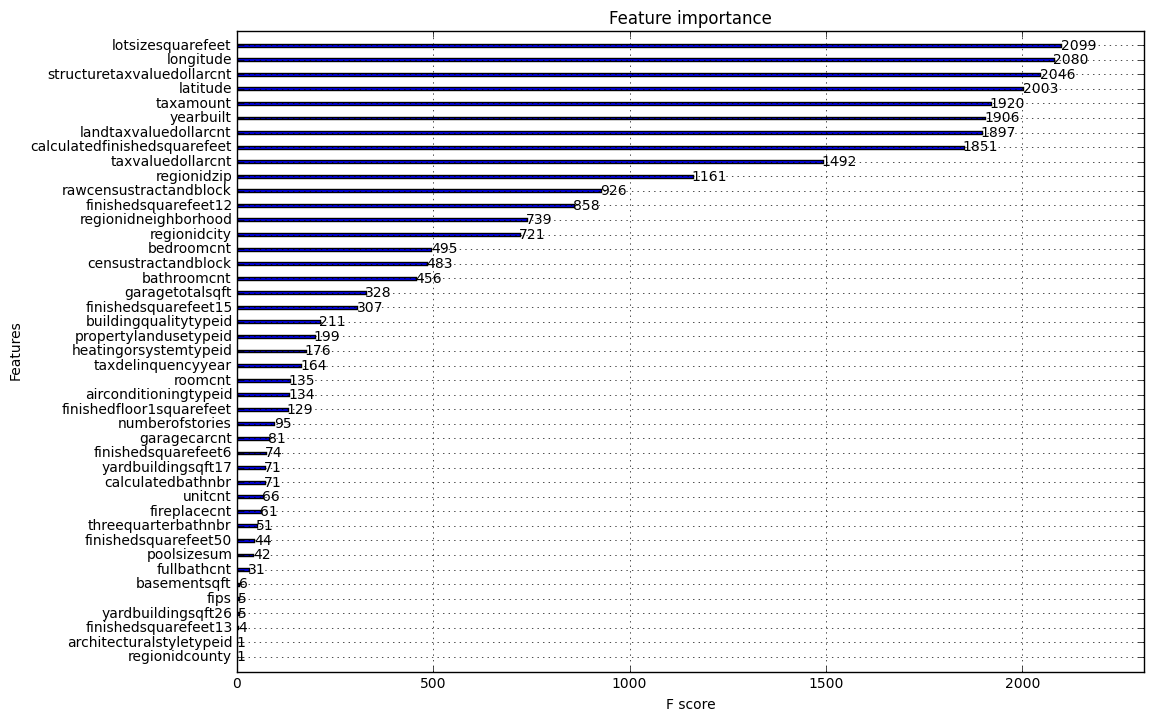

In [9]:
xgboost = XGBoost(xgb_params)
xgboost.train(x_train, y_train)
from xgboost import plot_importance
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plot_importance(xgboost.algorithm, ax=ax)

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

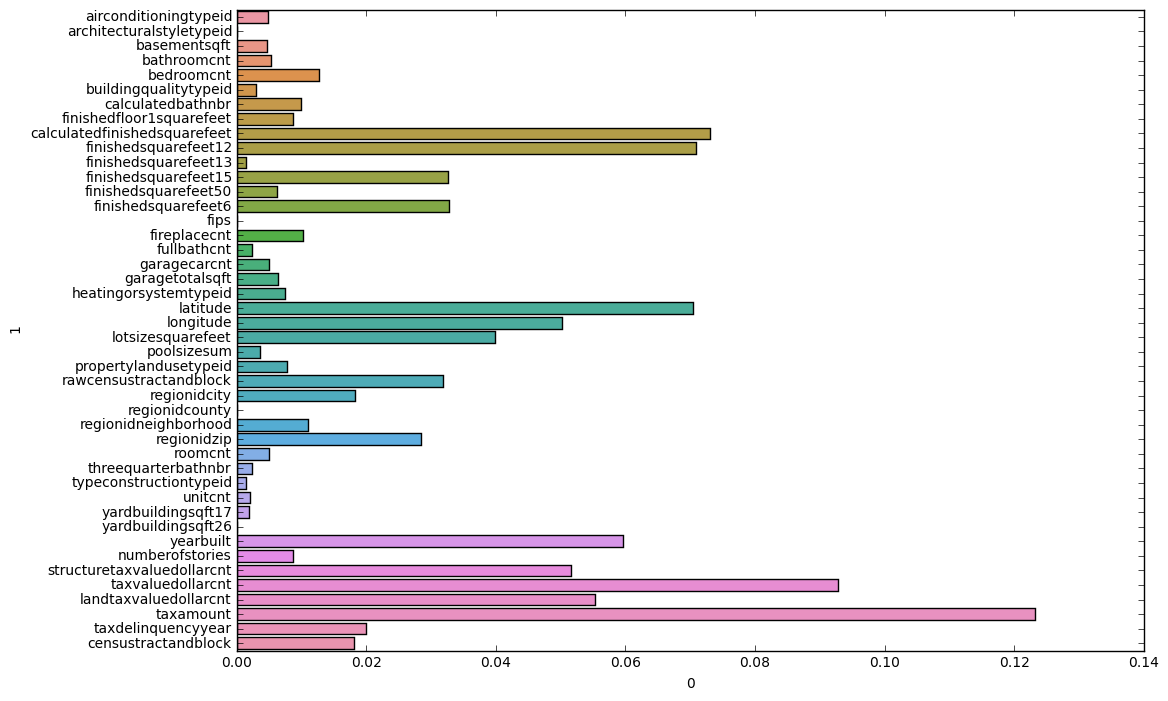

In [11]:
gb = GradientBoostingRegressor(**{})
gb.fit(x_train, y_train)
df = pd.DataFrame(zip(gb.feature_importances_, x_train.columns))
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax=ax, data=df, x=0, y=1)

In [14]:
from catboost import CatBoostRegressor

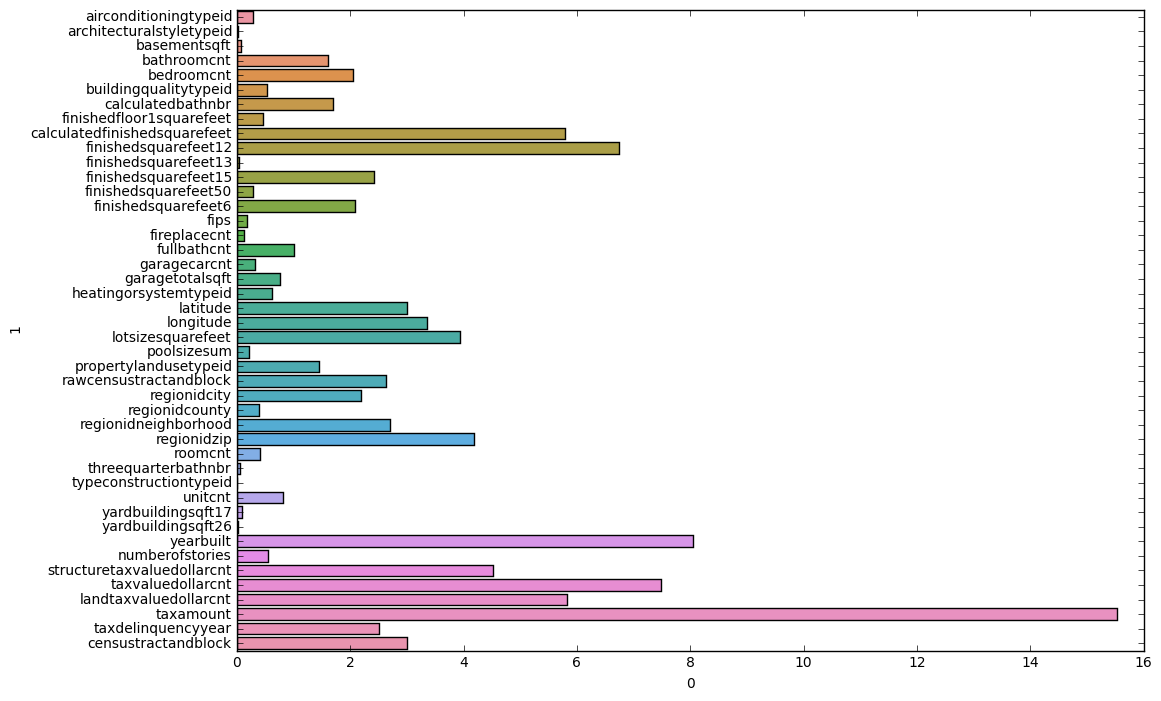

In [17]:
catboost = CatBoostRegressor()
catboost.fit(x_train, y_train)
df = pd.DataFrame(zip(catboost.feature_importances_, x_train.columns))
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax=ax, data=df, x=0, y=1)